In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import os
import copy
import seaborn as sn
import pandas as pd


tf.__version__

: 

In [177]:
#list of histone marks
histone_marks=[]
path='../data/GM12878_hg19_chip_seq/'
for val in sorted(os.listdir(path)):
    h=val.split('-')
    if len(h)>1:
        histone_marks.append(h[0])

histone_marks=np.unique(histone_marks)
# histone_marks=['RNA-seq']
print(histone_marks)

#combine experiment replicas
chip={'{}'.format(xx):{} for xx in histone_marks}

for mark in histone_marks:
    data=[xx for xx in os.listdir(path) if mark in xx]
    print(mark)
    for val in data:
        print(val)
        for ff in os.listdir(path+val):
            if 'chr' not in ff: continue
            if 'chrX' in ff: continue
            chrkey=ff.replace('.track','')
            # print(chrkey, chip[mark].keys())
            if chrkey in chip[mark].keys():
                # print('yellow')
                chip[mark][chrkey]=np.vstack((chip[mark][chrkey], np.loadtxt(path+val+'/'+ff, skiprows=3,usecols=2)))
            elif chrkey not in chip[mark].keys():
                # print('red')
                chip[mark][chrkey]=np.loadtxt(path+val+'/'+ff, skiprows=3,usecols=2)
        
    # for key in chip[mark].keys():
    #     print(key, chip[mark][key].shape)

#average the chip seq signals then normalize them to be between 0 and 1
norm_chip=copy.deepcopy(chip)
for key in chip.keys():
    print(key)
    for k2 in chip[key].keys():
        norm_chip[key][k2] = np.mean(chip[key][k2], axis=0)
        norm_chip[key][k2] -= norm_chip[key][k2].min()
        per=np.percentile(norm_chip[key][k2],98)
        norm_chip[key][k2] /= per #norm_chip[key][k2].max()
        norm_chip[key][k2][norm_chip[key][k2]>1]=1
        print(norm_chip[key][k2].min(), norm_chip[key][k2].max())
        # print(k2, chip[key][k2].shape, norm_chip[key][k2].shape)


#state (input) vector
vec=[]
neighbor=2
for mark in histone_marks:
    print(mark)
    row=norm_chip[mark]['chr1']
    # rowlen=row.shape[0]
    for jj in range(2,23):
        chrm='chr{}'.format(jj)
        row = np.concatenate((row,norm_chip[mark][chrm]))
        # rowlen+=norm_chip[mark][chrm].shape[0]
    # row=np.array(row)
    vec.append(row)
    for n in range(1,neighbor+1):
        vec.append(np.pad(row[n:],(0,n)))
        vec.append(np.pad(row[:-n],(n,0)))
    # print(row.shape,)
vec=np.array(vec).reshape(len(histone_marks)*(2*n+1),-1)
print(vec.shape, vec[1][4])

['H2AFZ' 'H3K27ac' 'H3K27me3' 'H3K36me3' 'H3K4me1' 'H3K4me2' 'H3K4me3'
 'H3K79me2' 'H3K9ac' 'H3K9me3' 'H4K20me1']
H2AFZ
H2AFZ-human_4
H2AFZ-human_1
H2AFZ-human_3
H2AFZ-human_2
H3K27ac
H3K27ac-human_2
H3K27ac-human_1
H3K27ac-human_4
H3K27ac-human_3
H3K27me3
H3K27me3-human_5
H3K27me3-human_4
H3K27me3-human_1
H3K27me3-human_2
H3K27me3-human_7
H3K27me3-human_3
H3K27me3-human_6
H3K36me3
H3K36me3-human_7
H3K36me3-human_3
H3K36me3-human_4
H3K36me3-human_1
H3K36me3-human_5
H3K36me3-human_2
H3K36me3-human_6
H3K4me1
H3K4me1-human_2
H3K4me1-human_1
H3K4me1-human_3
H3K4me1-human_4
H3K4me2
H3K4me2-human_1
H3K4me2-human_2
H3K4me2-human_3
H3K4me2-human_4
H3K4me3
H3K4me3-human_3
H3K4me3-human_6
H3K4me3-human_2
H3K4me3-human_7
H3K4me3-human_8
H3K4me3-human_9
H3K4me3-human_1
H3K4me3-human_4
H3K4me3-human_10
H3K4me3-human_5
H3K79me2
H3K79me2-human_3
H3K79me2-human_1
H3K79me2-human_2
H3K79me2-human_4
H3K9ac
H3K9ac-human_4
H3K9ac-human_2
H3K9ac-human_1
H3K9ac-human_3
H3K9me3
H3K9me3-human_1
H3K9me3-human_4

In [178]:
typepath='../data/GM12878_hg19_chip_seq/types/'
type_vec=np.loadtxt(typepath+'chr1_beads.txt.original', dtype=str, usecols=1)
for chrm in range(2,23):
    type_vec=np.concatenate((type_vec, np.loadtxt(typepath+'chr{}_beads.txt.original'.format(chrm), dtype=str, usecols=1)))
# type_vec=type_vec[type_vec!='NA']
vec=np.vstack((type_vec, vec))
print(chrm, type_vec.shape)

# print(vec[0])

22 (57671,)


In [179]:
indices_NA=np.where(vec[0]=='NA')[0]
indices_B4=np.where(vec[0]=='B4')[0]
indices=np.concatenate((indices_NA, indices_B4))
vec_red = np.delete(vec, indices, axis=1)

print(vec_red.shape)


(56, 52452)


In [180]:
type_to_int={'A1':0, 'A2':1, 'B1':2, 'B2':3, 'B3':4, 'B4':5, 'NA':6}
int_to_type={0:'A1', 1:'A2', 2:'B1', 3:'B2', 4:'B3', 5:'B4', 6:'NA'}

type_to_int_AB={'A1':0, 'A2':0, 'B1':1, 'B2':1, 'B3':1, 'B4':1, 'NA':2}

sub_to_comp={0:0,1:0,2:1,3:1,4:1,5:1,6:2}




In [181]:
X_train_pre=np.array(vec_red[1:].T, dtype=float)
Y_train_pre=np.array(list(map(type_to_int.get, vec_red[0])), dtype=float)

In [182]:
print(X_train_pre.shape, Y_train_pre.shape)
print(Y_train_pre, X_train_pre)

(52452, 55) (52452,)
[0. 0. 0. ... 0. 0. 0.] [[0.25305783 0.25857373 0.23425435 ... 0.29830003 0.48375563 0.30347389]
 [0.25857373 0.2684637  0.25305783 ... 0.30942137 1.         0.29830003]
 [0.2684637  0.34347346 0.25857373 ... 0.48216698 0.62886952 0.30942137]
 ...
 [0.76184431 0.59025987 0.82727197 ... 0.77712311 0.59913625 0.74505448]
 [0.59025987 0.84578674 0.76184431 ... 0.55412915 0.75110133 0.77712311]
 [0.84578674 0.4438697  0.59025987 ... 0.74750814 0.63725807 0.55412915]]


In [183]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_pre, Y_train_pre, test_size=0.4, random_state=1913)

In [184]:
for val in np.unique(Y_test):
    print(val, list(map(int_to_type.get, [val]))[0],np.where(Y_test==val)[0].shape[0]/Y_test.shape[0])

0.0 A1 0.15147037796101234
1.0 A2 0.22105714694247175
2.0 B1 0.1328344692817311
3.0 B2 0.16662694819122062
4.0 B3 0.3280110576235642


In [185]:
inputs = keras.Input(shape=X_train.shape[1])

# x1 = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(128, activation="relu",bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(64, activation="relu", bias_regularizer=tf.keras.regularizers.L2(0.001))(x)
# x = layers.add([x,x1])
# x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(np.unique(Y_train)), activation='relu')(x)

# del model
model = keras.Model(name="Predict-Chromatin-Types", inputs=inputs, outputs=outputs)
# model.add(outputs)

In [186]:
model.summary()

Model: "Predict-Chromatin-Types"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 55)]              0         
                                                                 
 dense_23 (Dense)            (None, 64)                3584      
                                                                 
 dense_24 (Dense)            (None, 128)               8320      
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 5)                 325       
                                                                 
Total params: 20,485
Trainable params: 20,4

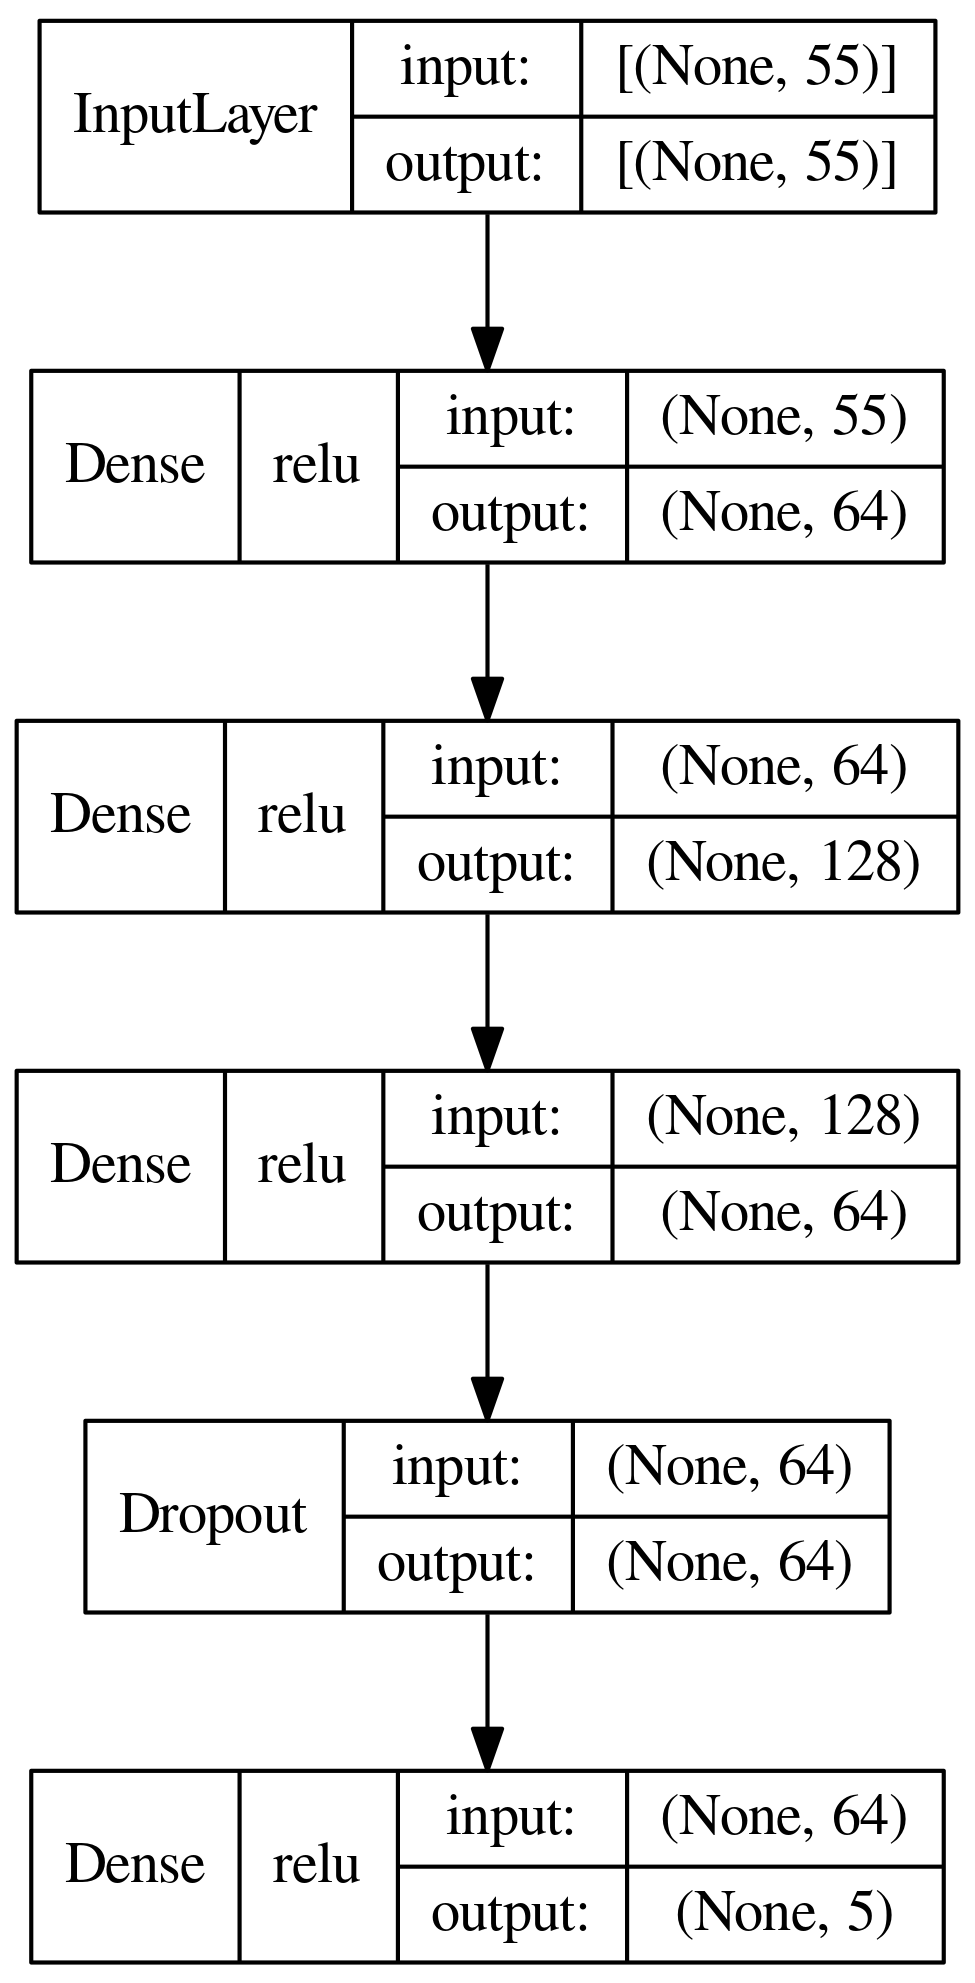

In [187]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=300, show_layer_names=False, show_layer_activations=True, rankdir='TB')

In [188]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=["accuracy"],
)

In [189]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=60, validation_split=0.2)

Epoch 1/60
394/394 [==============================] - 1s 3ms/step - loss: 1.3216 - accuracy: 0.4367 - val_loss: 1.1244 - val_accuracy: 0.5549
Epoch 2/60
394/394 [==============================] - 1s 2ms/step - loss: 1.1288 - accuracy: 0.5381 - val_loss: 1.0722 - val_accuracy: 0.5724
Epoch 3/60
394/394 [==============================] - 1s 3ms/step - loss: 1.0799 - accuracy: 0.5627 - val_loss: 1.0155 - val_accuracy: 0.5933
Epoch 4/60
394/394 [==============================] - 1s 3ms/step - loss: 1.0489 - accuracy: 0.5761 - val_loss: 0.9903 - val_accuracy: 0.6017
Epoch 5/60
394/394 [==============================] - 1s 3ms/step - loss: 1.0286 - accuracy: 0.5856 - val_loss: 0.9827 - val_accuracy: 0.5989
Epoch 6/60
394/394 [==============================] - 1s 3ms/step - loss: 1.0096 - accuracy: 0.5931 - val_loss: 0.9651 - val_accuracy: 0.6105
Epoch 7/60
394/394 [==============================] - 1s 3ms/step - loss: 0.9973 - accuracy: 0.5966 - val_loss: 0.9506 - val_accuracy: 0.6148
Epoch 

In [85]:
test_scores = model.evaluate(X_test, Y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

492/492 - 0s - loss: 0.8993 - accuracy: 0.6363 - 419ms/epoch - 852us/step
Test loss: 0.8993361592292786
Test accuracy: 0.6363116502761841


Text(0, 0.5, 'accuracy')

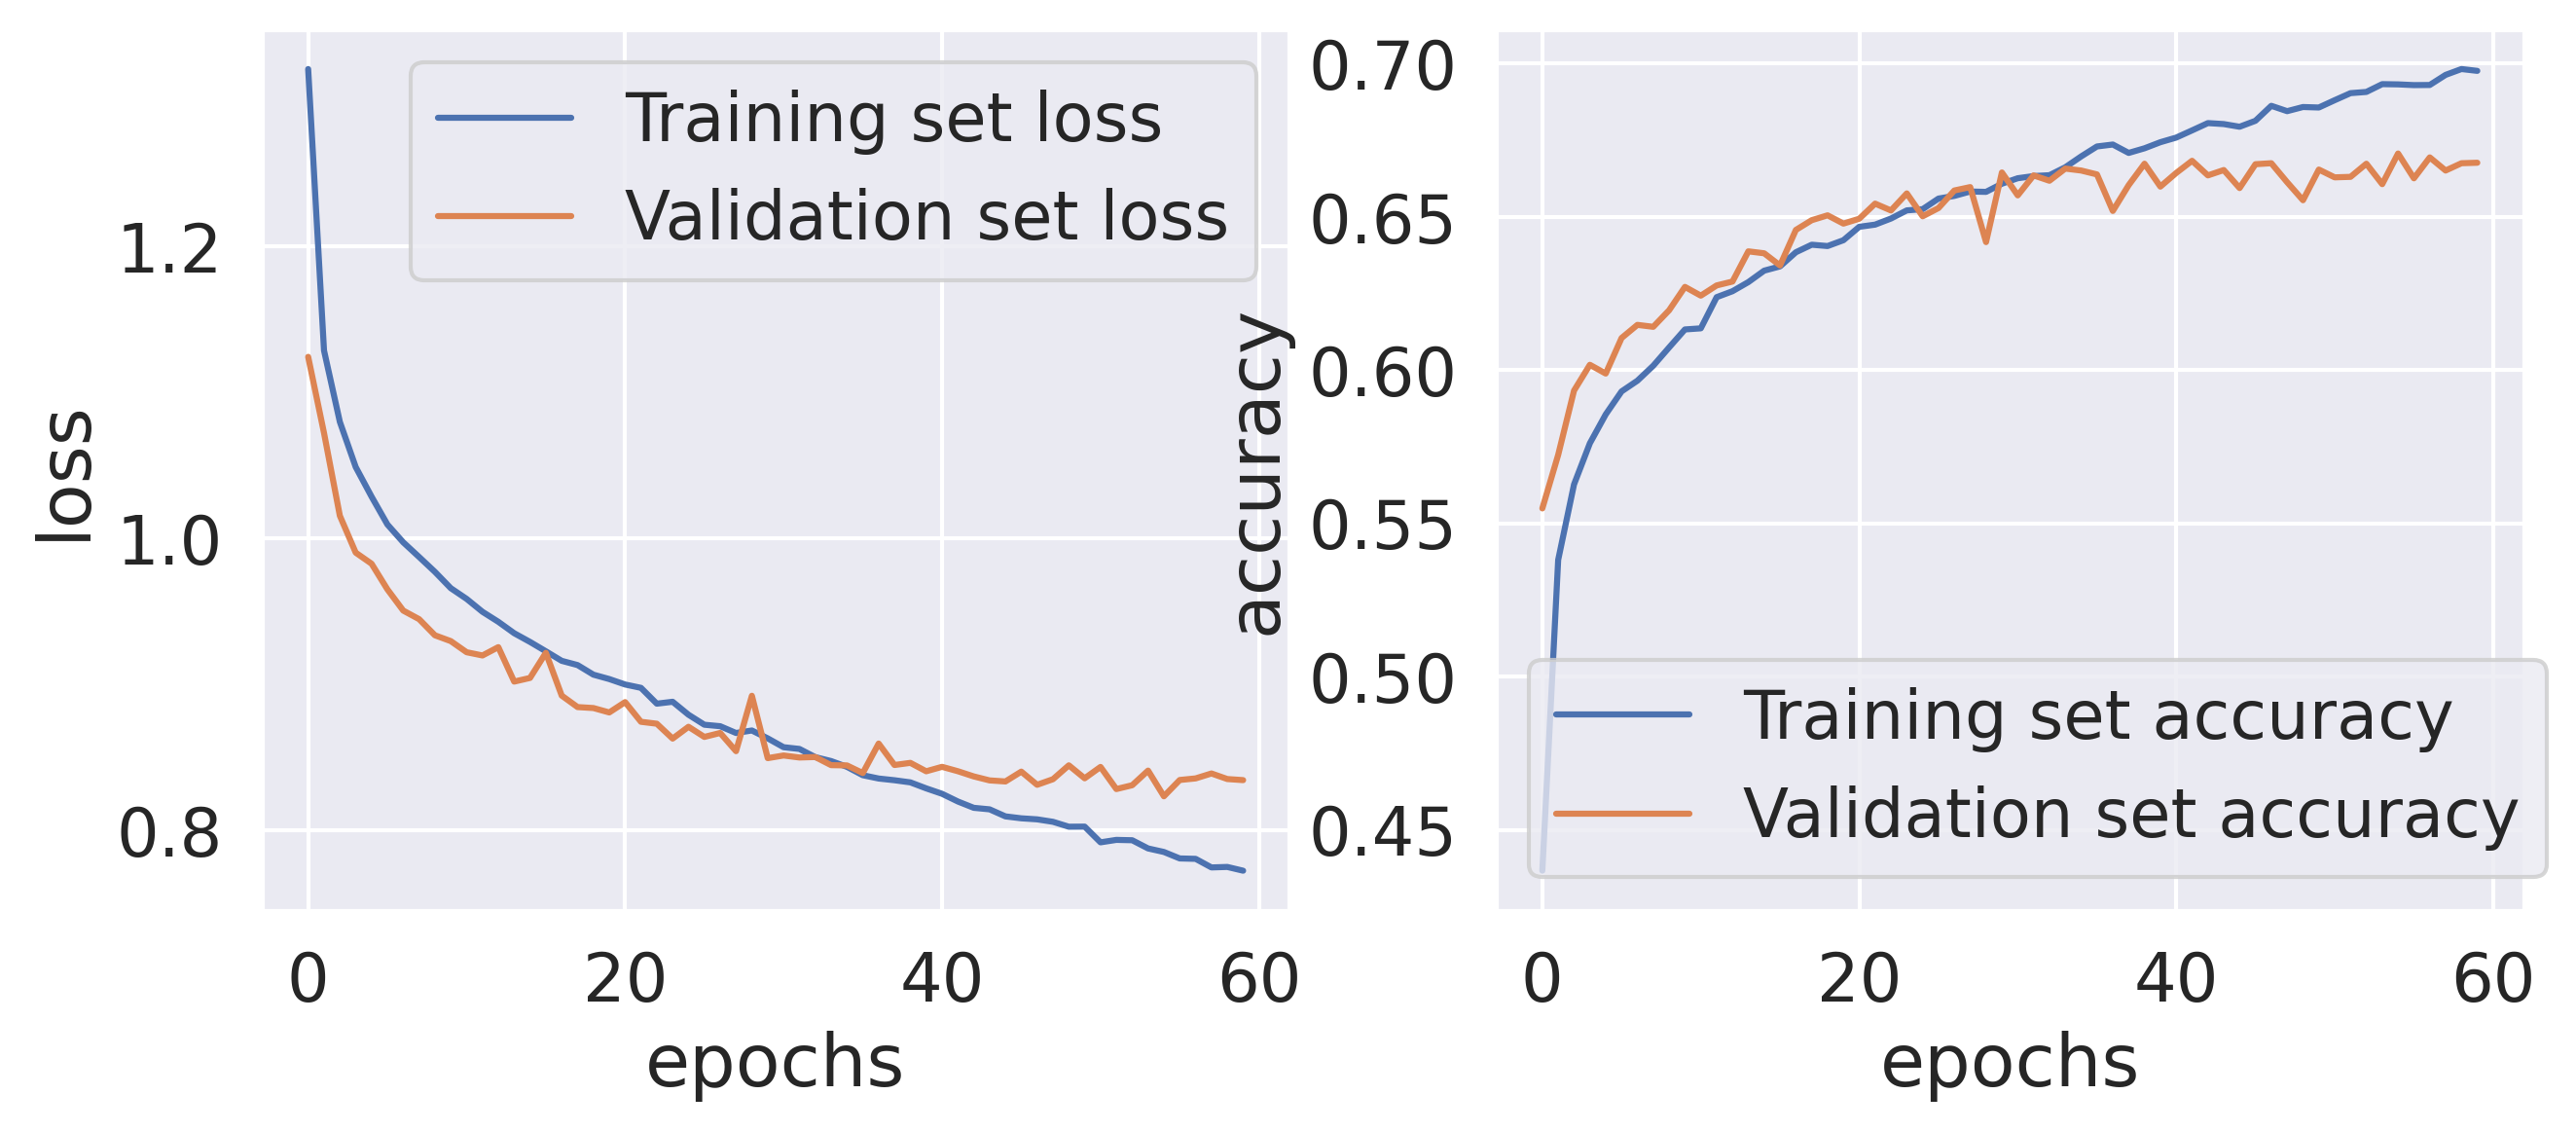

In [190]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,2, figsize=(10,4), dpi=300)

ax[0].plot(history.history['loss'],label="Training set loss")
ax[0].plot(history.history['val_loss'],label="Validation set loss")
ax[1].plot(history.history['accuracy'],label="Training set accuracy")
ax[1].plot(history.history['val_accuracy'],label="Validation set accuracy")

for axi in ax.flatten():
    axi.set_xlabel('epochs')
    axi.legend()
ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

In [16]:
print(Y_test.shape, X_test.shape)
type_test={}

for val in np.unique(Y_test):
    ind = np.where(Y_test==val)[0]
    X_type=X_test[ind,:]
    Y_type=Y_test[ind]
    name=list(map(int_to_type.get, [val]))[0]

    print(name, Y_type.shape, X_type.shape)
    type_test[name] = (X_type,Y_type)

print(type_test.keys())


(20981,) (20981, 55)
A1 (3178,) (3178, 55)
A2 (4638,) (4638, 55)
B1 (2787,) (2787, 55)
B2 (3496,) (3496, 55)
B3 (6882,) (6882, 55)
dict_keys(['A1', 'A2', 'B1', 'B2', 'B3'])


In [49]:
for key in type_test.keys():
    print("Type: ", key)
    test_scores = model.evaluate(type_test[key][0], type_test[key][1], verbose=2)
    print("Test loss:", test_scores[0])
    print("Test accuracy:", test_scores[1])

Type:  A1
75/75 - 0s - loss: 0.9420 - accuracy: 0.6552 - 62ms/epoch - 830us/step
Test loss: 0.9420308470726013
Test accuracy: 0.6552013158798218
Type:  A2
110/110 - 0s - loss: 0.9718 - accuracy: 0.6392 - 80ms/epoch - 727us/step
Test loss: 0.9718381762504578
Test accuracy: 0.6391899585723877
Type:  B1
66/66 - 0s - loss: 1.1265 - accuracy: 0.6175 - 54ms/epoch - 819us/step
Test loss: 1.1265114545822144
Test accuracy: 0.6175071597099304
Type:  B2
83/83 - 0s - loss: 0.9232 - accuracy: 0.6146 - 104ms/epoch - 1ms/step
Test loss: 0.9232333898544312
Test accuracy: 0.6145952343940735
Type:  B3
160/160 - 0s - loss: 0.6465 - accuracy: 0.7798 - 176ms/epoch - 1ms/step
Test loss: 0.6464784145355225
Test accuracy: 0.7797770500183105


In [123]:
pred=model(X_test)
pred_label=tf.argmax(pred,1)

print(Y_test[0:3])
print(pred_label[0:3])
# print(Y_test[0:3])

[4. 2. 1.]
tf.Tensor([4 1 1], shape=(3,), dtype=int64)


In [124]:
conf_mat=tf.math.confusion_matrix(Y_test.astype(int), pred_label, dtype=tf.dtypes.float32)

In [125]:
print(conf_mat)

tf.Tensor(
[[1.546e+03 7.090e+02 1.310e+02 2.000e+00 1.400e+01]
 [5.810e+02 2.334e+03 2.300e+02 1.600e+01 2.990e+02]
 [2.930e+02 3.360e+02 1.182e+03 8.000e+01 2.390e+02]
 [1.300e+01 1.410e+02 2.410e+02 1.192e+03 1.017e+03]
 [3.000e+01 4.630e+02 2.740e+02 1.970e+02 4.176e+03]], shape=(5, 5), dtype=float32)


In [126]:
conf_mat_norm=normalize(conf_mat, norm='l1')

In [127]:
print(conf_mat_norm)

[[0.64363031 0.29517069 0.05453789 0.00083264 0.00582848]
 [0.16791908 0.67456647 0.06647399 0.00462428 0.08641618]
 [0.13755869 0.15774648 0.55492958 0.03755869 0.11220657]
 [0.00499232 0.05414747 0.09254992 0.4577573  0.390553  ]
 [0.00583658 0.09007782 0.05330739 0.03832685 0.81245136]]


<AxesSubplot:>

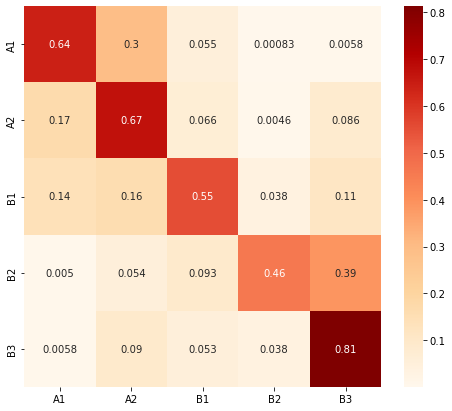

656/656 [==============================] - 0s 524us/step
[1. 1. 1. 1. 1.] [0.92028617 1.03684299 0.95481538 1.11110628 0.97694918]
[3138. 5125. 2074. 2176. 8468.] 
 [3178. 4638. 2787. 3496. 6882.]
[3178, 4638, 2787, 3496, 6882] 
 [3138, 5125, 2074, 2176, 8468]


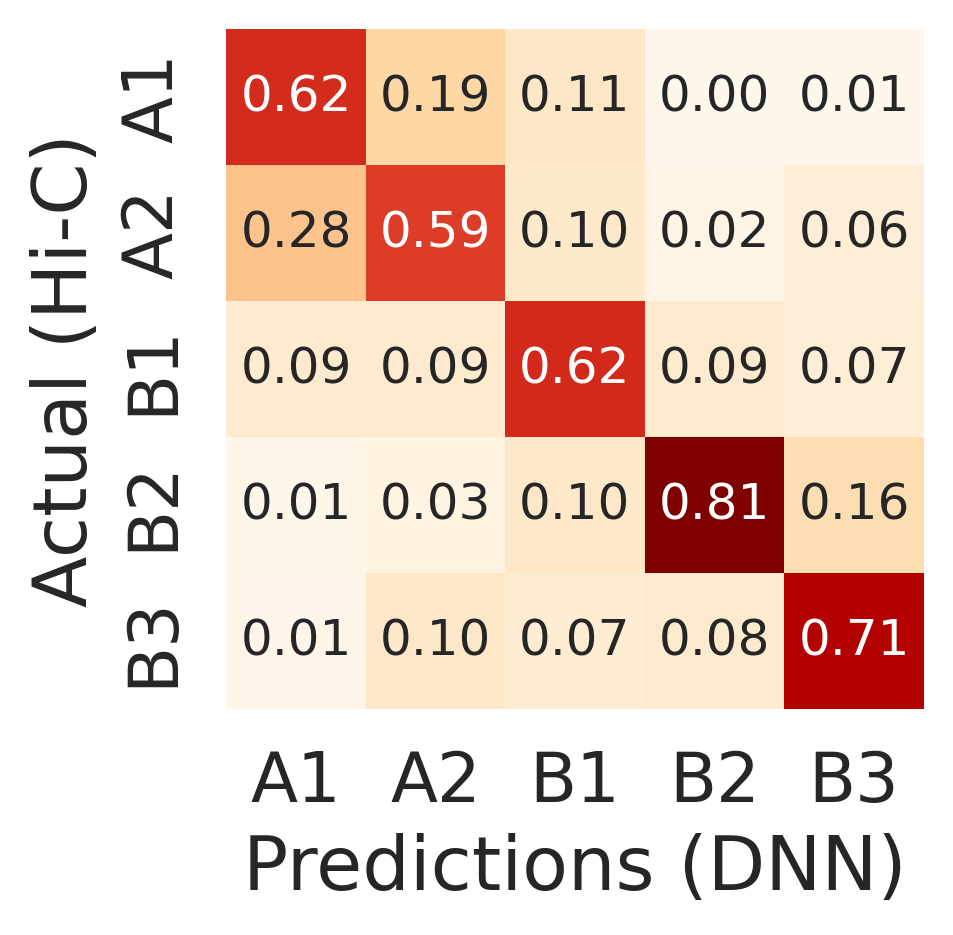

In [191]:

pred=model.predict(X_test)
pred_label=tf.argmax(pred,1)

pred_label_AB=[]

for val in pred_label:
    if val<2: pred_label_AB.append(0)
    else: pred_label_AB.append(1)
pred_label_AB = tf.convert_to_tensor(pred_label_AB,dtype=tf.int32)
test_label_AB=[]
for val in Y_test:
    if val<2: test_label_AB.append(0)
    else: test_label_AB.append(1)
test_label_AB=tf.convert_to_tensor(test_label_AB, dtype=tf.int32)

# predAB=list(pred.numpy()) #tf.map_fn(sub_to_comp.get,pred,fn_output_signature=tf.int32)
# conf_matAB=
# print(type(predAB), pred)
conf_mat=tf.math.confusion_matrix(Y_test.astype(int), pred_label,  dtype=tf.dtypes.float32)
conf_mat_norm=normalize(conf_mat, norm='l1', axis=0)

print(np.sum(conf_mat_norm, axis=0), np.sum(conf_mat_norm, axis=1))
df_cm = pd.DataFrame(conf_mat_norm, index = ['A1','A2','B1','B2','B3'],
              columns = ['A1','A2','B1','B2','B3'])

# df_cm = pd.DataFrame(conf_mat_norm, index = ['A','B'],
#               columns = ['A','B'])


plt.figure(figsize = (3,3), dpi=300)
ax=sn.heatmap(df_cm, annot=True,cmap="OrRd", annot_kws={'fontsize':12}, fmt='.2f', cbar=False)
sn.set(font_scale=1.2)
ax.set(xlabel='Predictions (DNN)', ylabel='Actual (Hi-C)')

print(np.sum(conf_mat, axis=0), '\n', np.sum(conf_mat, axis=1))
print([Y_test[Y_test==xx].shape[0] for xx in np.unique(Y_test)], '\n', [pred_label[pred_label==xx].shape[0] for xx in np.unique(pred_label)])

Text(-35.25, 0.5, 'Actual (Hi-C)')

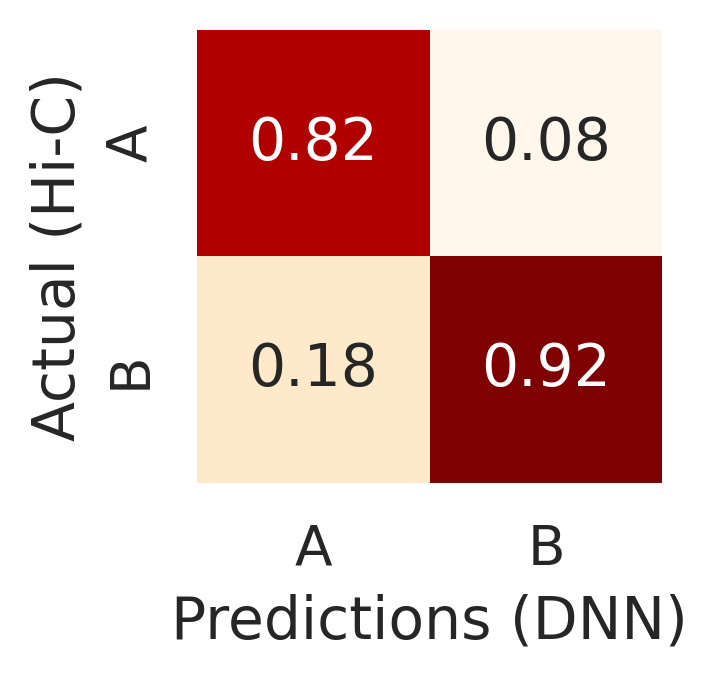

In [192]:
conf_mat_AB=tf.math.confusion_matrix( test_label_AB, pred_label_AB, dtype=tf.dtypes.int32)
conf_mat_AB_norm=normalize(conf_mat_AB, norm='l1', axis=0)

df_cm = pd.DataFrame(conf_mat_AB_norm, index = ['A','B'],
              columns = ['A','B'])

# df_cm = pd.DataFrame(conf_mat_norm, index = ['A','B'],
#               columns = ['A','B'])


plt.figure(figsize = (2,2), dpi=300)
ax=sn.heatmap(df_cm, annot=True,cmap="OrRd", annot_kws={'fontsize':14}, fmt='.2f', cbar=False)
sn.set(font_scale=1.5)
ax.set_xlabel('Predictions (DNN)',fontsize=14)
ax.set_ylabel('Actual (Hi-C)', fontsize=14)


(0.0, 1.1)

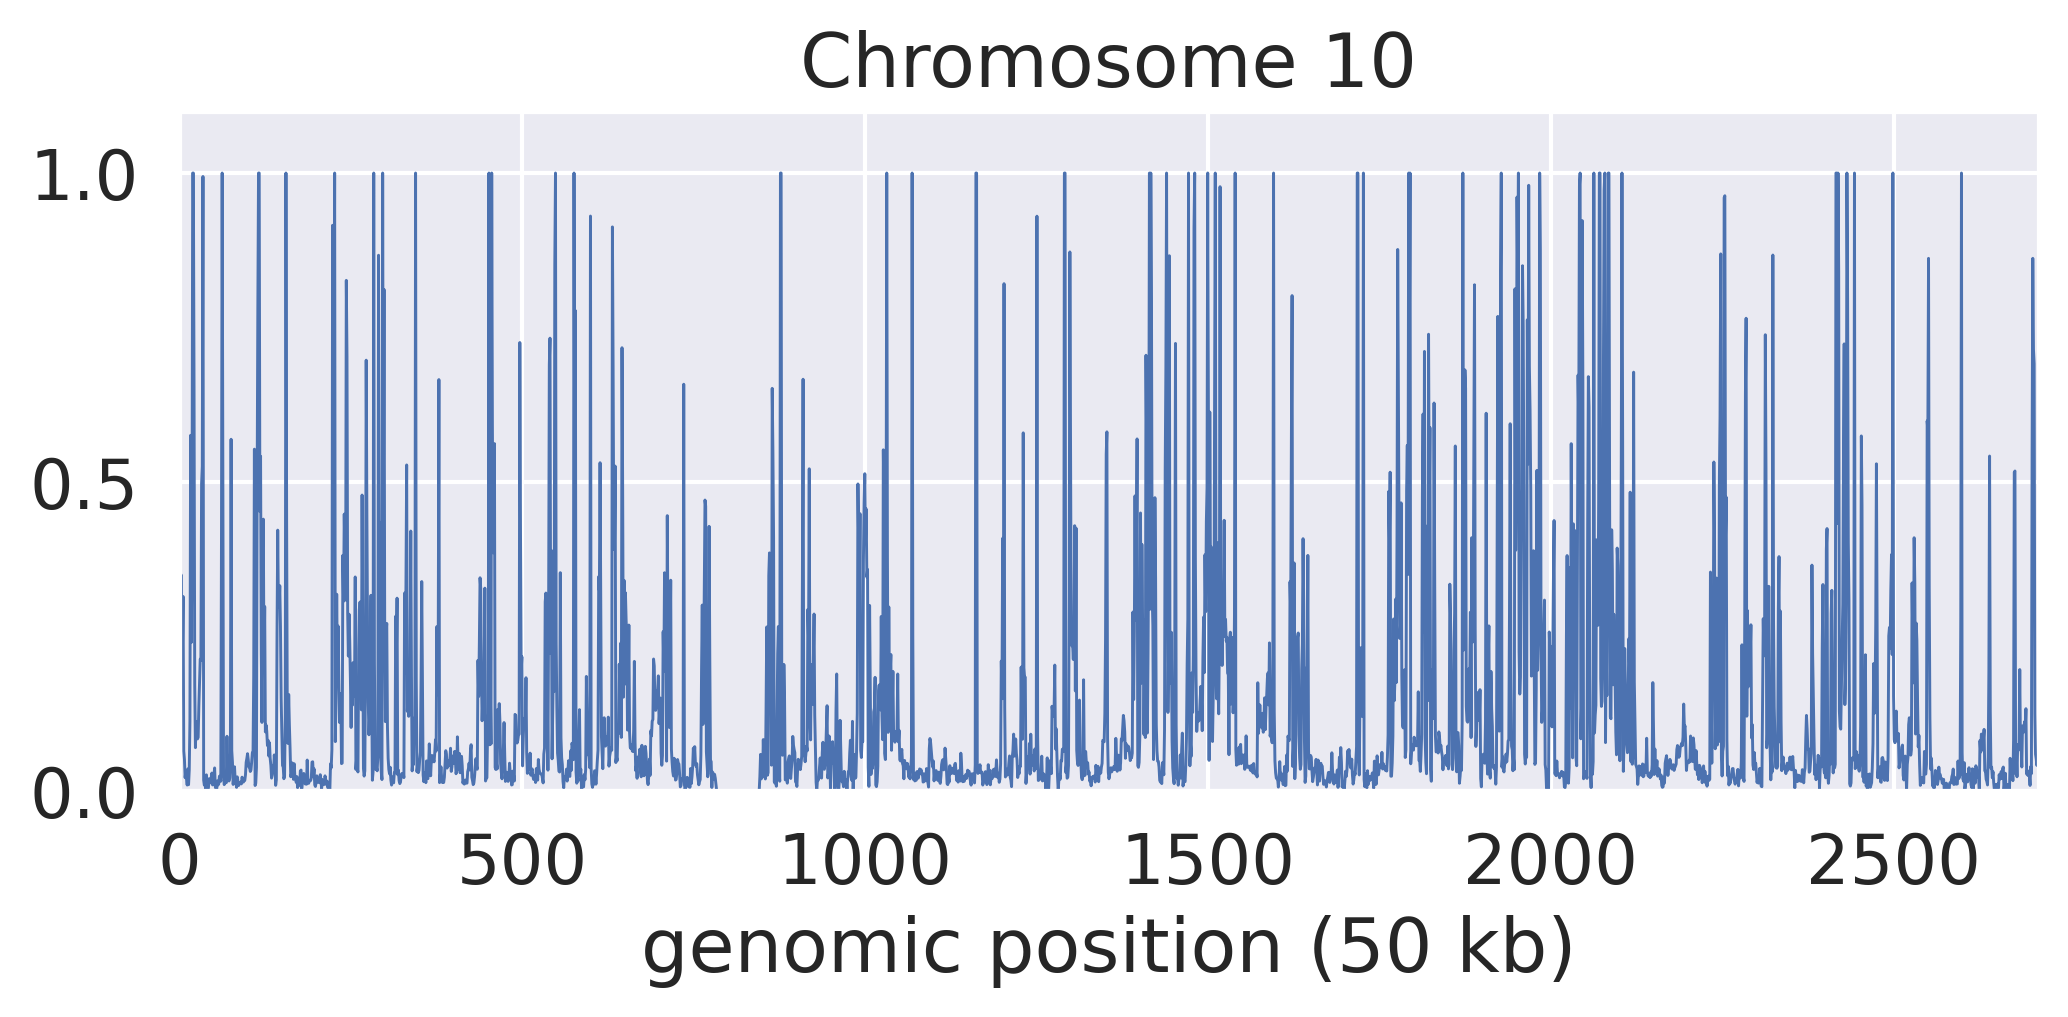

In [176]:
norm_chip['RNA-seq']['chr1'].shape
plt.figure(figsize=(8,3), dpi=300)

plt.plot(norm_chip['RNA-seq']['chr10'], lw=0.7)
plt.title('Chromosome 10')
plt.xlim(0,norm_chip['RNA-seq']['chr10'].shape[0])
plt.xlabel('genomic position (50 kb)')
plt.ylim(0,1.1)